# Chapter 11: Deep neural network (DNN)

### 11.1. Intuition behind DNN
> ###### 11.1.1. Forward propagation
> ###### 11.1.2. Gradient descent
> ###### 11.1.3. Backpropagation

### 11.2. DDN for classification
> ###### 11.2.1. Preparation of data
> ###### 11.2.2. Implement a DNN for a classification task
> ###### 11.2.3. Prediction and backtest

### 11.3. DNN for regression
> ###### 11.3.1. Implement a DNN for a regression task
> ###### 11.3.2. Custom loss function
> ###### 11.3.3. Prediction and backtest

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
from Backtest import *
np.random.seed(56)

### 11.2.1. Preparation of data 

In [2]:
# Import the data
df = yf.download("AAPL", end="2021-01-01")[["Adj Close"]].pct_change(1)
df.columns = ["returns"]

# Features engeeniring
df["returns t-1"] = df[["returns"]].shift(1)

# Mean of returns
df["mean returns 15"] = df[["returns"]].rolling(15).mean().shift(1)
df["mean returns 60"] = df[["returns"]].rolling(60).mean().shift(1)

# Volatility of returns
df["volatility returns 15"] = df[["returns"]].rolling(15).std().shift(1)
df["volatility returns 60"] = df[["returns"]].rolling(60).std().shift(1)

# Drop missing values
df = df.dropna()

# Percentage train set
split = int(0.80*len(df))

# Train set creation
X_train = df[["returns t-1", "mean returns 15", "mean returns 60",
              "volatility returns 15",
              "volatility returns 60"]].iloc[:split]

y_train_reg = df[["returns"]].iloc[:split]

y_train_cla = np.round(df[["returns"]].iloc[:split]+0.5)


# Test set creation
X_test = df[["returns t-1", "mean returns 15", "mean returns 60",
              "volatility returns 15",
              "volatility returns 60"]].iloc[split:]

y_test_reg = df[["returns"]].iloc[split:]
y_test_cla = np.round(df[["returns"]].iloc[split:]+0.5)


# NORMALIZATION 
# Import the class
from sklearn.preprocessing import StandardScaler

# Initialize the class
sc = StandardScaler()

# Standardize the data
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

[*********************100%***********************]  1 of 1 completed


### 11.2.2. Implement a DNN for a classification task

In [3]:
np.random.seed(15)
# LIBAIRIES
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

nb_hidden_layer = 1


# INTIALIZATION SEQUENTIAL MODEL
classifier = Sequential()

# AJOUT COUCHE DENSE ET DROPOUT
for _ in range(nb_hidden_layer):
    classifier.add(Dense(75, input_shape = (X_train.shape[1],), activation="relu"))


# AJOUT COUCHE DENSE
classifier.add(Dense(1, activation="sigmoid"))

# COMPILATION DU MODÈLE
classifier.compile(loss="binary_crossentropy", optimizer="adam")

# TRAINING
classifier.fit(X_train_scaled, y_train_cla, epochs=15, batch_size=150, verbose=1)

Epoch 1/15
54/54 [==============================] - 1s 2ms/step - loss: 0.6979
Epoch 2/15
54/54 [==============================] - 0s 2ms/step - loss: 0.6927
Epoch 3/15
54/54 [==============================] - ETA: 0s - loss: 0.690 - 0s 2ms/step - loss: 0.6918
Epoch 4/15
54/54 [==============================] - 0s 2ms/step - loss: 0.6914
Epoch 5/15
54/54 [==============================] - 0s 2ms/step - loss: 0.6912
Epoch 6/15
54/54 [==============================] - 0s 2ms/step - loss: 0.6907
Epoch 7/15
54/54 [==============================] - 0s 2ms/step - loss: 0.6907
Epoch 8/15
54/54 [==============================] - 0s 2ms/step - loss: 0.6905
Epoch 9/15
54/54 [==============================] - 0s 2ms/step - loss: 0.6901
Epoch 10/15
54/54 [==============================] - 0s 2ms/step - loss: 0.6903
Epoch 11/15
54/54 [==============================] - 0s 2ms/step - loss: 0.6902
Epoch 12/15
54/54 [==============================] - 0s 2ms/step - loss: 0.6896
Epoch 13/15
54/54 [======

### 10.2.3. Predictions and backtest

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 1.23 	 Alpha: 17.49 %	     Sharpe: 0.594 	 Sortino: 0.841
  -----------------------------------------------------------------------------
    VaR: 85.05 %	 cVaR: 101.36 % 	     VaR/cVaR: 1.192 	 drawdown: 81.8 %
  -----------------------------------------------------------------------------


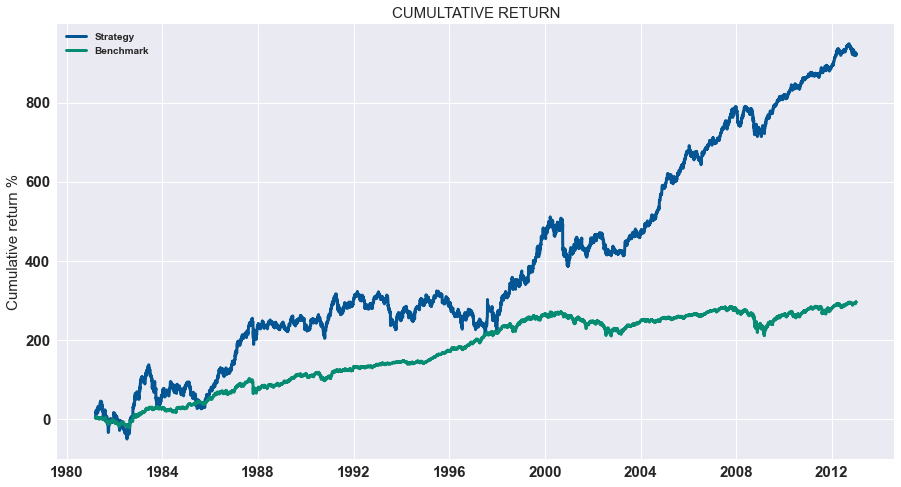

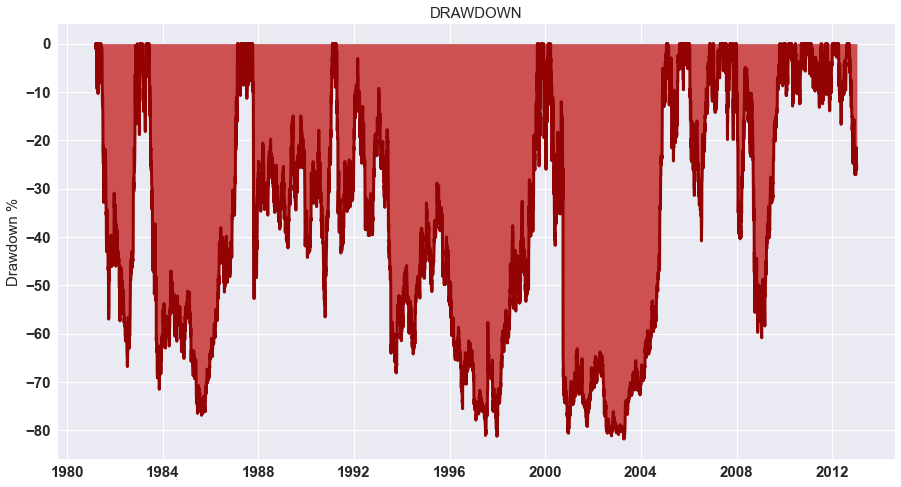

In [6]:
# Create predictions for the whole dataset
df["prediction"] = classifier.predict(np.concatenate((X_train,X_test),
                                    axis=0))
df["prediction"] = np.where(df["prediction"] == 0, -1,1)
# Compute the strategy
df["strategy"] = np.sign(df["prediction"]) * df["returns"]

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[:split], save="ANNClassifier")

### 10.3.1. Implement a DNN for a regression task¶

In [12]:
np.random.seed(15)# LIBAIRIES
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

nb_hidden_layer = 1


# INTIALIZATION SEQUENTIAL MODEL
regressor = Sequential()

# ADD HIDDEN LAYER
for _ in range(nb_hidden_layer):
    regressor.add(Dense(75, input_shape = (X_train.shape[1],), activation="relu"))


# OUTPUT LAYER DENSE
regressor.add(Dense(1, activation="linear"))

# COMPILE THE MODEL
regressor.compile(loss="mse", optimizer="adam")

# TRAINING
regressor.fit(X_train_scaled, y_train_reg, epochs=13, batch_size=32, verbose=1)

Epoch 1/13
251/251 [==============================] - 1s 1ms/step - loss: 0.0416
Epoch 2/13
251/251 [==============================] - 0s 771us/step - loss: 0.0021
Epoch 3/13
251/251 [==============================] - 0s 787us/step - loss: 0.0018
Epoch 4/13
251/251 [==============================] - 0s 830us/step - loss: 0.0015
Epoch 5/13
251/251 [==============================] - 0s 789us/step - loss: 0.0014
Epoch 6/13
251/251 [==============================] - 0s 790us/step - loss: 0.0012
Epoch 7/13
251/251 [==============================] - 0s 795us/step - loss: 0.0011
Epoch 8/13
251/251 [==============================] - 0s 843us/step - loss: 0.0012
Epoch 9/13
251/251 [==============================] - 0s 983us/step - loss: 0.0011
Epoch 10/13
251/251 [==============================] - 0s 787us/step - loss: 0.0011
Epoch 11/13
251/251 [==============================] - 0s 988us/step - loss: 0.0011
Epoch 12/13
251/251 [==============================] - 0s 954us/step - loss: 0.0011
Epo

[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Beta: 1.127 	 Alpha: 15.55 %	     Sharpe: 1.065 	 Sortino: 1.396
  -----------------------------------------------------------------------------
    VaR: 36.33 %	 cVaR: 45.6 % 	     VaR/cVaR: 1.255 	 drawdown: 38.52 %
  -----------------------------------------------------------------------------


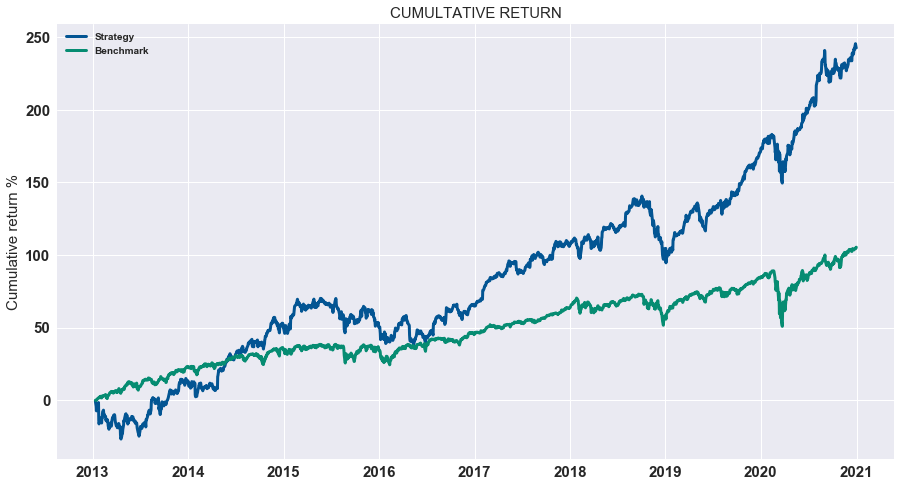

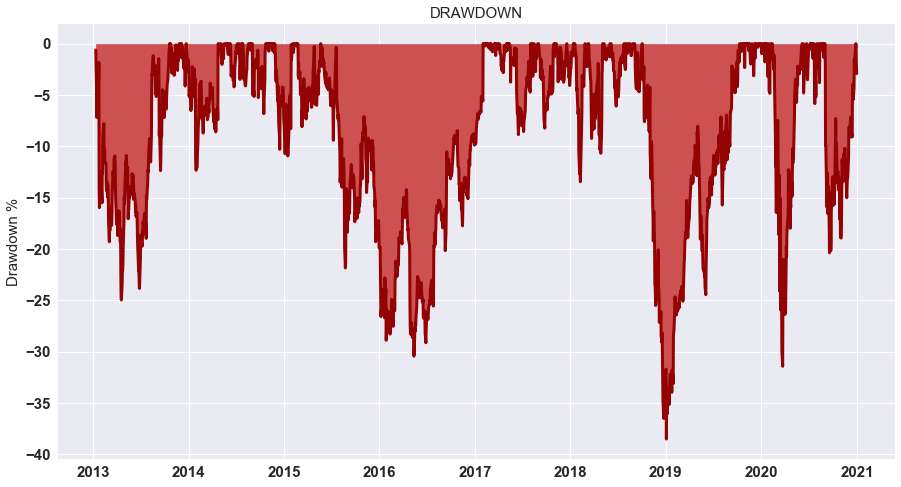

In [13]:
# Create predictions for the whole dataset
df["prediction"] = regressor.predict(np.concatenate((X_train,X_test),
                                    axis=0))

# Compute the strategy
df["strategy"] = np.sign(df["prediction"]) * df["returns"]

# Backtest
backtest_dynamic_portfolio(df["strategy"].iloc[split:], save="MSE")

In [9]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras.backend as F

def ALPHA_MSE(y_true, y_pred):
    y_true_roll = tf.roll(y_true, shift=1, axis=0)
    y_pred_roll = tf.roll(y_pred, shift=1, axis=0)
    y_true_dif = tf.math.sign(y_true_roll-y_true)
    y_pred_dif = tf.math.sign(y_pred_roll-y_pred)
    booleen_vector = y_true_dif == y_pred_dif
    alpha = tf.where(booleen_vector, 1, 3)
    alpha = tf.cast(alpha, dtype=tf.float32)
    mse = F.square(y_true-y_pred)
    mse = tf.cast(mse, dtype=tf.float32)
    scale_mse = tf.multiply(alpha, mse)
    alpha_mse = F.mean(scale_mse)
    return alpha_mse

Epoch 1/13
251/251 [==============================] - 1s 1ms/step - loss: 0.0055
Epoch 2/13
251/251 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 3/13
251/251 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 4/13
251/251 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 5/13
251/251 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 6/13
251/251 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 7/13
251/251 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 8/13
251/251 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 9/13
251/251 [==============================] - 0s 999us/step - loss: 0.0018
Epoch 10/13
251/251 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 11/13
251/251 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 12/13
251/251 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 13/13
251/251 [==

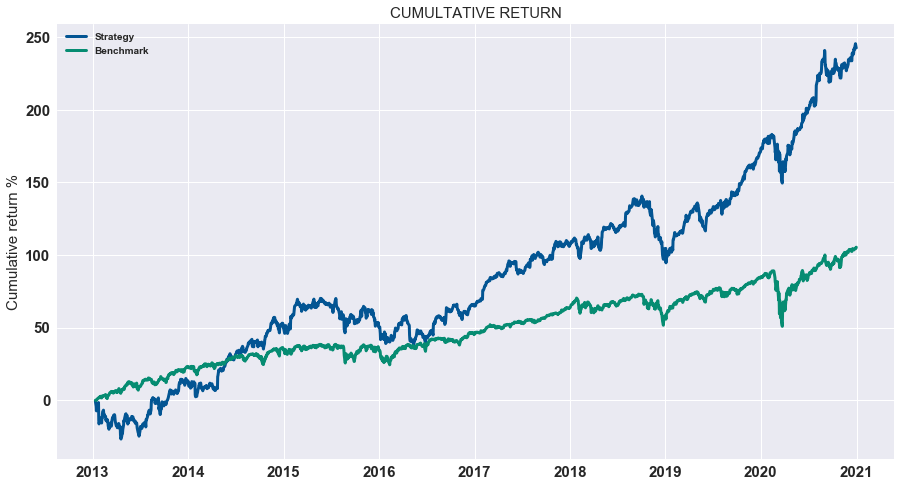

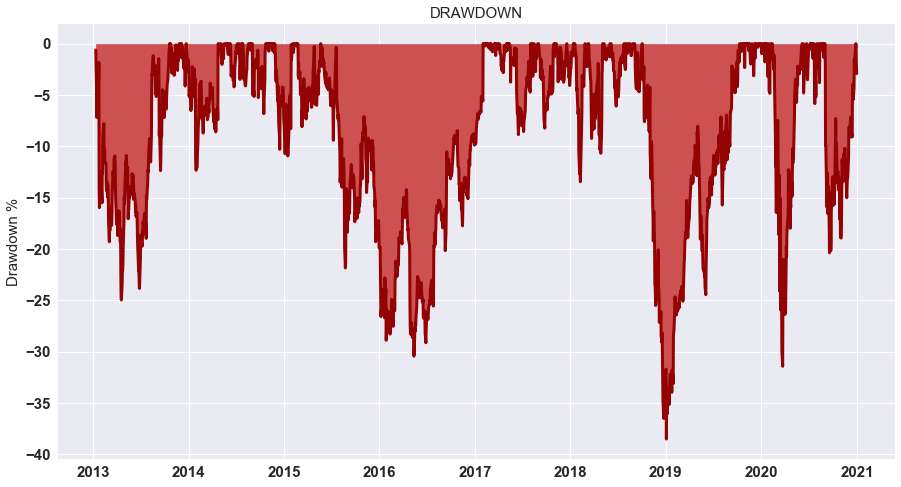

In [10]:
# LIBAIRIES
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

nb_hidden_layer = 3

np.random.seed(15)
# INTIALIZATION SEQUENTIAL MODEL
regressor = Sequential()

# AJOUT COUCHE DENSE ET DROPOUT
for _ in range(nb_hidden_layer):
    regressor.add(Dense(75, input_shape = (X_train.shape[1],), activation="relu"))


# AJOUT COUCHE DENSE
regressor.add(Dense(1, activation="linear"))

# COMPILATION DU MODÈLE
regressor.compile(loss=ALPHA_MSE, optimizer="adam")

regressor.fit(X_train_scaled, y_train_reg, epochs=13, batch_size=32, verbose=1)

# Create predictions for the whole dataset
df["prediction"] = regressor.predict(np.concatenate((X_train,X_test),
                                    axis=0))

# Compute the strategy
df["strategy"] = np.sign(df["prediction"]) * df["returns"]

# Backtest
from Backtest import *
backtest_dynamic_portfolio(df["strategy"].iloc[split:])